# Практическое задание №4 по теме "Uplift-моделирование".

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных на тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: 
    * одна модель с признаком коммуникации (S learner), 
    * модель с трансформацией таргета (трансформация классов п. 2. 1),
    * вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
    * сделать прогноз и получить uplift для тестовой выборки 
    * отсортировать тестовую выборку по uplift по убыванию 
    * разбить на децили (pandas qcut вам в помощь) 
    * для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve
from catboost import CatBoostClassifier

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import warnings
warnings.filterwarnings('ignore')

## Задание №1

In [2]:
df = pd.read_csv('data.csv')
df.sample(5, random_state=12)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
4107,2,149.82,1,0,Surburban,1,Web,No Offer,0
43930,12,98.28,1,0,Urban,1,Phone,Discount,0
30369,9,434.25,1,0,Urban,1,Phone,Buy One Get One,0
61339,2,41.08,1,0,Urban,0,Web,Discount,0
56686,2,40.31,1,0,Urban,1,Phone,No Offer,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


## Задание №2

In [4]:
df.rename(columns={'conversion': 'target'}, inplace=True)
df.rename(columns={'offer': 'treatment'}, inplace=True)

In [5]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
df['treatment'] = df['treatment'].map({'Buy One Get One':1, 'Discount':1, 'No Offer':0})

## Задание №4

dummies для категорийных признаков:

In [7]:
# df = pd.get_dummies(df, prefix='zc', columns = ['zip_code'])
# df = pd.get_dummies(df, prefix='ch',columns = ['channel'])

Модели почему-то хуже предсказывают, если делать dummies. Особенно это касается ClassTransformation. Поэтому решил не делать данное преобразование признаков.

Бокс-Кокс для 'history':

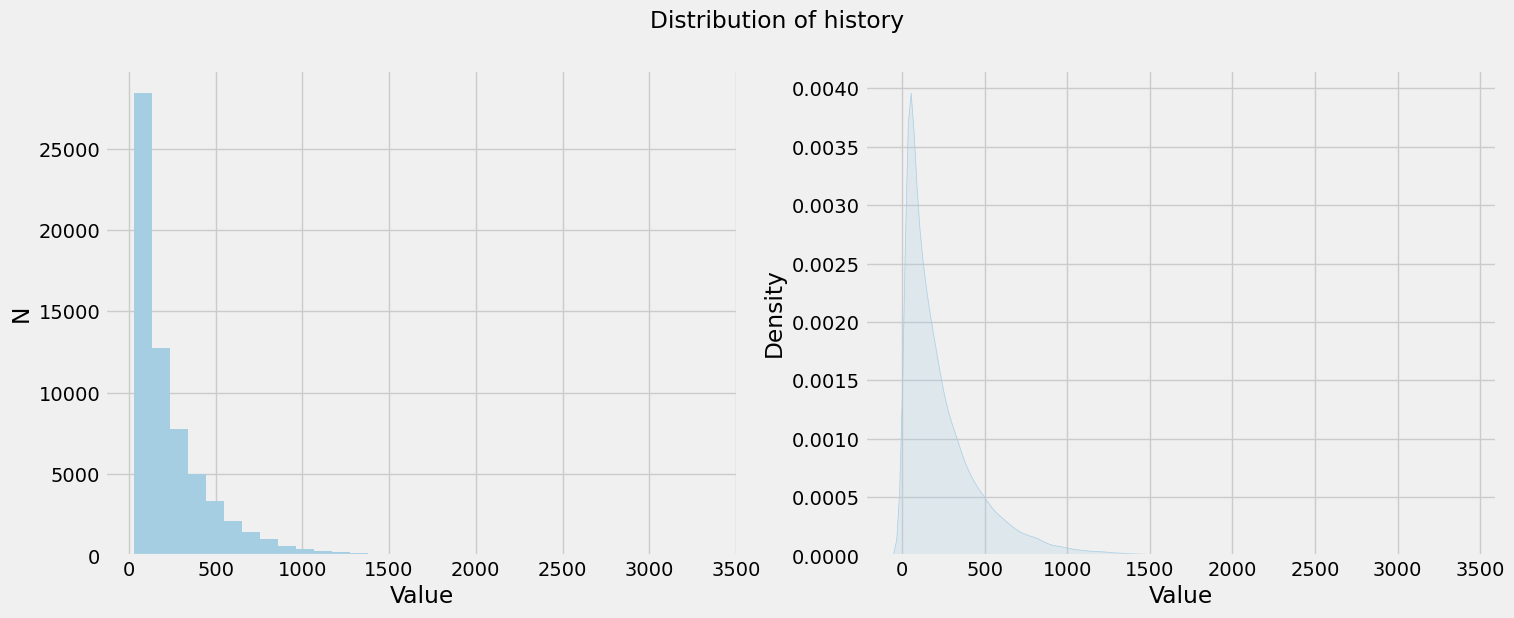

In [8]:
plt.figure(figsize = (16, 6))

plt.subplot(121)
df['history'].hist(density=False, bins=32)
plt.ylabel('N')
plt.xlabel('Value')

plt.subplot(122)
sns.kdeplot(df['history'], shade=True, legend=False)
plt.xlabel('Value')
plt.ylabel('Density')

plt.suptitle('Distribution of history')
plt.show()

In [9]:
x_log, lyamb = stats.boxcox(df['history'])

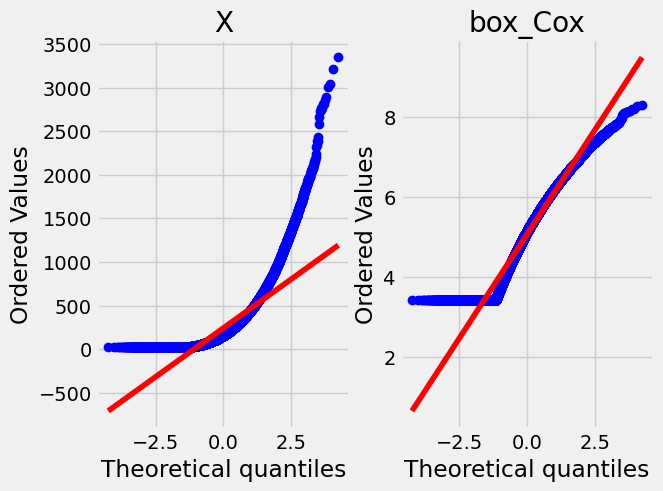

In [10]:
fig1, (ax1, ax2) = plt.subplots(1, 2)

p1 = stats.probplot(df['history'], dist=stats.norm, plot=ax1)
p2 = stats.probplot(x_log, dist=stats.norm, plot=ax2)

ax1.set_title('X')
ax2.set_title('box_Cox')

plt.show()

In [11]:
df['history'] = x_log

In [12]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,5.030560,1,0,Surburban,0,Phone,1,0
1,6,5.894336,1,1,Rural,1,Web,0,0
2,7,5.275268,0,1,Surburban,1,Web,1,0
3,9,6.640004,1,0,Rural,1,Web,1,0
4,2,3.856478,1,0,Urban,0,Web,1,0


## Задание №3

In [13]:
# features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zc_Rural', 'zc_Surburban',
#                  'zc_Urban', 'ch_Multichannel', 'ch_Phone', 'ch_Web']

features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code', 'channel']

In [14]:
# разбиение на тренировочную и тестовую выборки
indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=123)

# данные для обучения
X_train = df.loc[indices_train, features]
y_train = df.loc[indices_train, 'target']
treat_train = df.loc[indices_train, 'treatment']

# данные для теста
X_test = df.loc[indices_test, features]
y_test = df.loc[indices_test, 'target']
treat_test = df.loc[indices_test, 'treatment']

# категорийные признаки
cat_features = ['zip_code', 'channel']

# словарь для записи результатов 
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
}

## Задание №5

#### 1. Одна модель с признаком коммуникации (S-learner)

In [15]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

In [16]:
sm_score_20, sm_score_10

(0.0789944802657288, 0.08925430023455824)

#### 2. Одна модель с трансформацией таргета

In [17]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [18]:
ct_score_10, ct_score_20

(0.1174110633307271, 0.09579975087924972)

#### 3.  Две независимые модели

In [19]:
tm = TwoModels(    
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)   
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)
tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

In [20]:
tm_score_10, tm_score_20

(0.07830580531665363, 0.06843890435717076)

## Задание №6

Solo Model


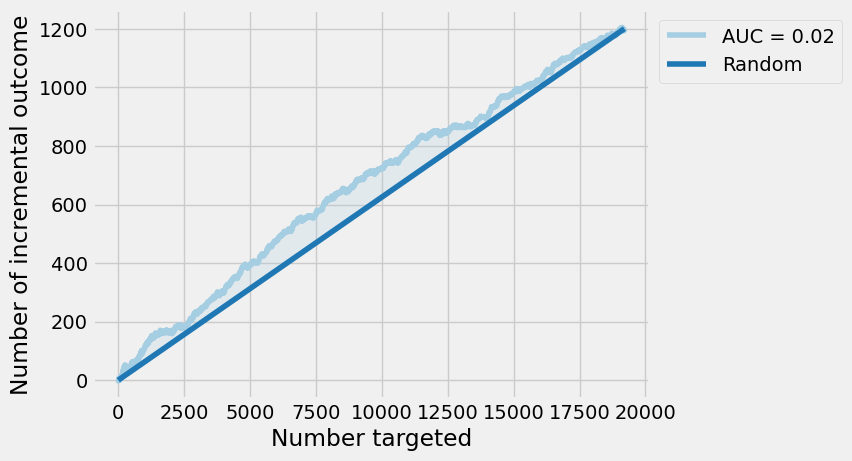

ClassTransform Model


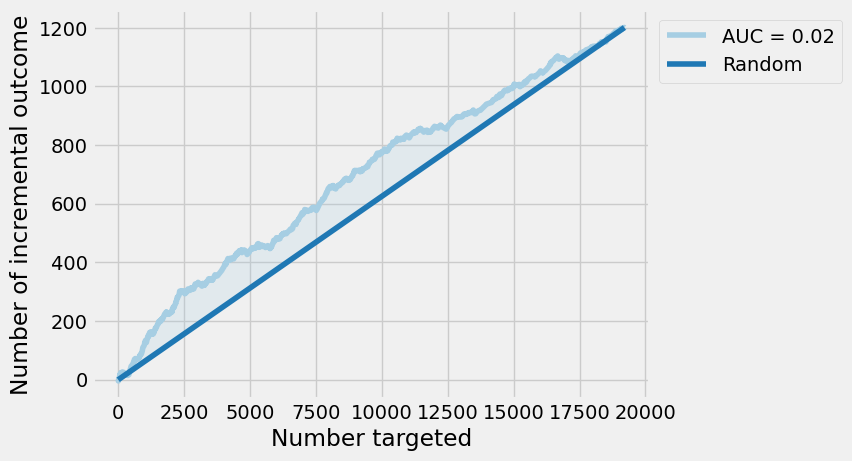

Two Model


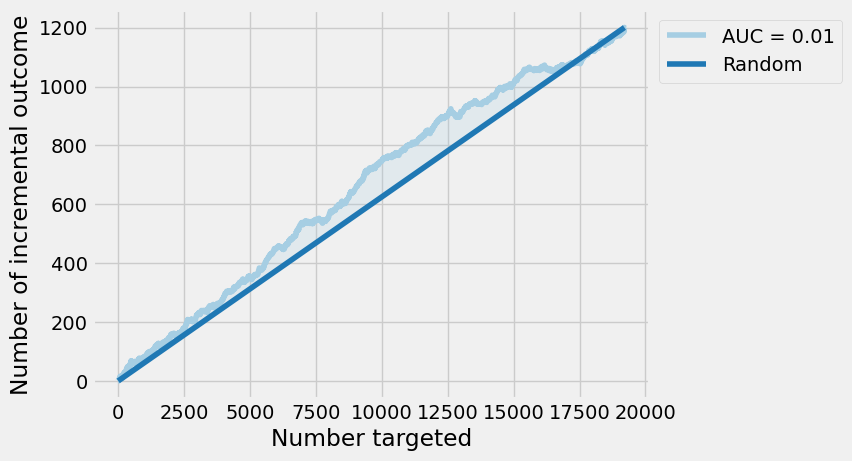

In [21]:
print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

In [22]:
result_df = pd.DataFrame(models_results).set_index('approach')
result_df.T

approach,SoloModel,ClassTransformation,TwoModels
uplift@10%,0.089254,0.117411,0.078306
uplift@20%,0.078994,0.095800,0.068439


Лучший результат показала модель ClassTransformation.

## Задание №7

In [23]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), pd.get_dummies(X_train['zip_code'], prefix='zc')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), pd.get_dummies(X_train['channel'], prefix='ch')], 1)
features = [col for col in X_train_tree]

In [24]:
X_train_tree.head()

,recency,history,used_discount,used_bogo,is_referral,zc_Rural,zc_Surburban,zc_Urban,ch_Multichannel,ch_Phone,ch_Web
53181,8,4.867520,0,1,0,0,1,0,0,0,1
42635,9,6.546508,0,1,1,0,0,1,0,1,0
6296,5,5.303236,1,0,1,1,0,0,0,0,1
41722,1,5.984427,0,1,0,1,0,0,0,0,1
32660,10,5.010426,1,0,0,0,0,1,0,0,1


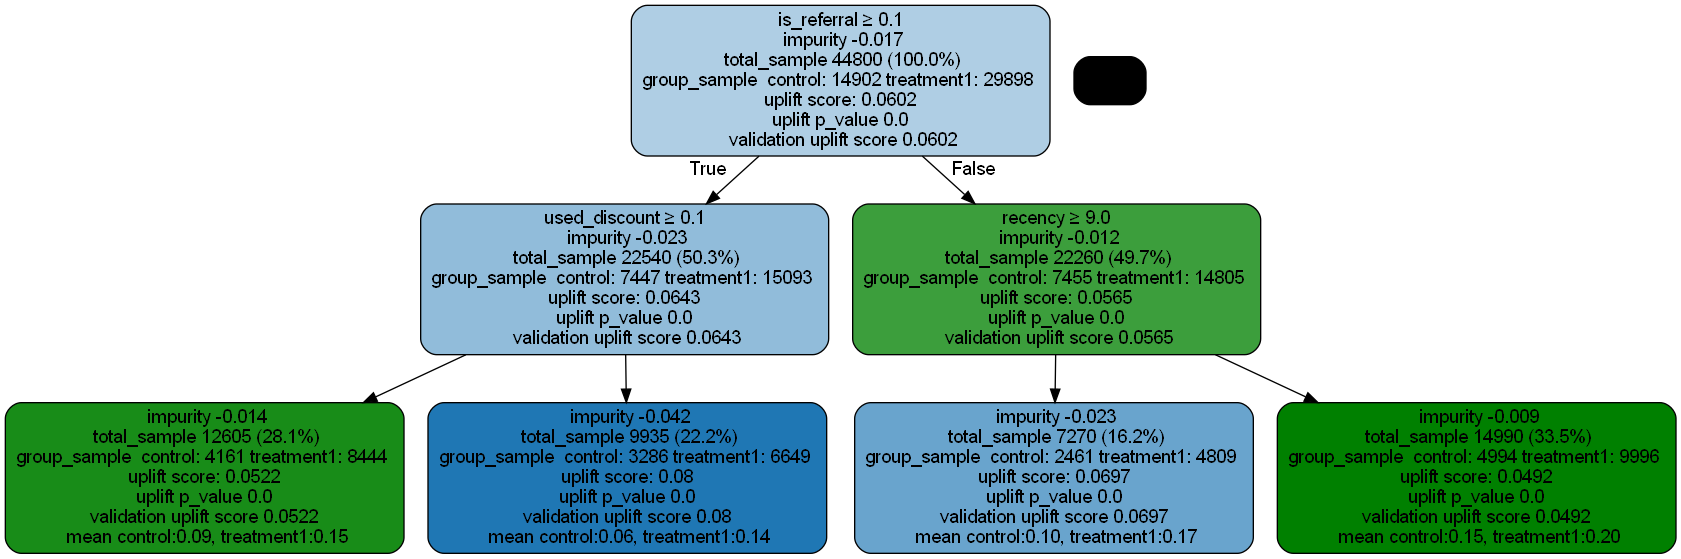

In [25]:
uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

**Описание дерева**

На вход (корень) подается вся выборка(100%), score=0.0602. Если признак **is_referral** > 0.1, тогда

--> True: группа из 22540 объектов (50.3%), score=0.0643. Если признак **used_discount** > 0.1, тогда

$\;\;\;\;\;$---> True: группа из 12605 объектов (28.1%), score=0.0522. 

$\;\;\;\;\;$---> False: группа из 9935 объектов (22.2%), score=0.08. 

--> False: группа из 22260 объектов (49.7%), score=0.0565. Если признак **recency** >= 9, тогда

$\;\;\;\;\;$---> True: группа из 7270 объектов (16.2%), score=0.0697. 

$\;\;\;\;\;$---> False: группа из 14990 объектов (33.5%), score=0.0492. 

## Задание №8, 9

Дополнительные опциональные задания, решил их не выпонлять.

---